## Flowerpot Experiment
30 subjects rated the similarity of 16 plants with different stem lengths and leaf shapes. Can we create a similarity preserving representation, that allows us to embed new plants into the embedding space without asking the humans again for their similarity judgements?

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import str, range
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
import keras

from simec import SimilarityEncoder
from utils import center_K

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# copy the data from the original paper (dissimilarities!) - ES (elongation/size) experiment 
# ("Representations of Qualitative and Quantitative Dimensions" by I.Gati & A. Tversky, 1982)
S = np.array(
    [[ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [ 7.9,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [ 9.5,  5.1,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [10.2,  7.3,  5.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [ 3.8, 12.6, 12.3, 14.9,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [10.7,  4.5,  9.0, 10.5, 10.6,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [11.2,  7.3,  4.3,  7.7, 10.6,  5.7,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [11.9,  9.8,  7.6,  4.2, 13.0,  9.1,  5.9,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [ 6.7, 15.4, 16.3, 17.6,  4.3, 13.6, 14.4, 15.7,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [15.4,  7.1, 12.8, 15.8, 12.1,  4.9, 10.6, 12.5, 10.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [15.4, 11.9,  7.5, 11.0, 13.2,  9.8,  4.8,  8.5, 12.0,  7.3,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
     [16.4, 15.0, 11.1,  6.5, 14.9, 13.4,  8.2,  5.1, 13.8, 10.6,  6.6,  0.0,  0.0,  0.0,  0.0,  0.0],
     [ 9.0, 17.7, 18.5, 19.1,  5.8, 15.9, 16.8, 18.2,  4.4, 13.8, 14.7, 16.5,  0.0,  0.0,  0.0,  0.0],
     [17.7,  9.1, 14.1, 17.1, 15.2,  6.9, 12.7, 15.5, 12.1,  4.3,  9.3, 12.9, 11.1,  0.0,  0.0,  0.0],
     [17.2, 13.9,  9.3, 12.9, 16.4, 12.7,  6.8,  9.8, 13.8,  8.4,  4.3,  8.1, 11.5,  6.8,  0.0,  0.0],
     [18.7, 15.8, 11.6,  8.8, 16.9, 15.1, 10.3,  6.0, 15.2, 13.0,  8.2,  3.5, 13.7, 11.1,  5.8,  0.0]])
# elongation/form experiment (not used here)
S_EF = np.array(
    [[ 0.0,  8.4,  9.9, 10.3,  6.3, 15.2, 14.9, 17.6,  8.6, 15.2, 15.7, 18.1,  8.9, 17.0, 17.2, 18.3],
     [ 0.0,  0.0,  6.2,  8.0, 15.1,  8.0, 11.5, 15.1, 16.7,  8.2, 13.1, 15.9, 17.2, 10.1, 14.9, 16.8],
     [ 0.0,  0.0,  0.0,  6.0, 15.8, 11.8,  7.6, 11.5, 16.2, 12.9,  8.3, 12.6, 17.3, 15.2,  9.9, 13.1],
     [ 0.0,  0.0,  0.0,  0.0, 17.3, 14.4, 13.2,  7.0, 17.9, 15.8, 14.8,  7.8, 18.4, 16.1, 15.6,  9.6],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  8.3, 10.0, 11.1,  5.1, 13.1, 12.6, 14.8,  7.0, 15.1, 14.9, 17.0],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  5.9,  7.4, 13.3,  5.3,  9.3, 11.8, 15.2,  7.2, 12.5, 15.0],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  5.5, 13.7,  9.9,  5.3,  9.5, 16.4, 12.1,  7.6, 12.1],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, 13.8, 11.5, 10.3,  5.5, 17.0, 15.5, 12.6,  6.6],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  8.8,  9.7, 10.7,  5.0, 12.4, 13.0, 14.3],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  5.1,  8.8, 12.0,  6.0,  9.2, 12.0],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  6.7, 12.6,  9.6,  6.3,  8.9],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, 14.9, 12.0,  9.7,  5.1],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  8.5,  9.4,  9.6],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  5.1,  6.8],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  5.5],
     [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0]])
# make the matrix symmetric
S += S.T
# normalize to 1: 20 was the highest rating possible (= most dissimilar),
# subract from 1 to transform into similarities and then center the matrix
S = center_K(1.-S/20.)
# split into random train/test set
np.random.seed(25)
idx = np.random.permutation(S.shape[0])
print(idx)
y = idx[:14]
y_test = idx[14:]
S_train = S[np.ix_(y, y)]

[13 12  0  3 11  9  5  1 15  8  2  7  6 10 14  4]


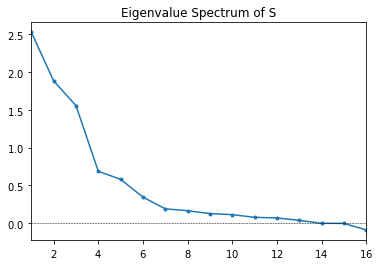

In [3]:
# plot eigenvalue spectrum (there is a negative eigenvalue! :O)
plt.figure();
plt.plot(list(range(1, S.shape[0]+1)), np.linalg.eigvalsh(S)[::-1], '-o', markersize=3);
plt.plot([1,S.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, S.shape[0]);
plt.title('Eigenvalue Spectrum of S');

In [4]:
def plot_flowerpots_2d(X, y, X_test=None, y_test=None):
    """
    Inputs:
        - X: nx2 feature vectors
        - y: corresponding labels describing the n data points (e.g. the numbers 1..n)
    """
    plt.figure()
    for i, l in enumerate(y):
        plt.text(X[i,0], X[i,1], str(l), color='#103864', fontdict={'weight': 'bold', 'size': 18});
    if not X_test is None:
        for i, l in enumerate(y_test):
            plt.text(X_test[i,0], X_test[i,1], str(l), color='#931d33', fontdict={'weight': 'bold', 'size': 18});
    s = 0.1*(np.max(X) - np.min(X))
    plt.xlim(np.min(X[:,0])-s, np.max(X[:,0])+s);
    plt.ylim(np.min(X[:,1])-s, np.max(X[:,1])+s);
    plt.xticks([],[]);
    plt.yticks([],[]);

MSQ Error: 0.02863


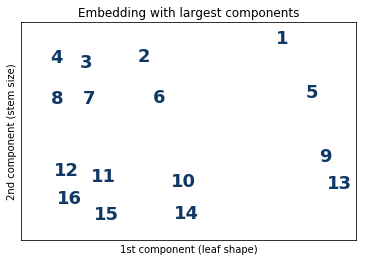

In [5]:
# plot first 2 components (of full matrix)
D, V = np.linalg.eig(S)
D, V = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V.real[:,:2], np.diag(np.sqrt(np.abs(D.real[:2]))))
plot_flowerpots_2d(X_embed, list(range(1, 17)));
plt.title('Embedding with largest components');
plt.xlabel('1st component (leaf shape)');
plt.ylabel('2nd component (stem size)');
S_approx = np.dot(X_embed, X_embed.T)
print("MSQ Error: %.5f" % np.mean((S/np.abs(S).max() - S_approx/np.abs(S_approx).max())**2))

MSQ Error: 0.19102


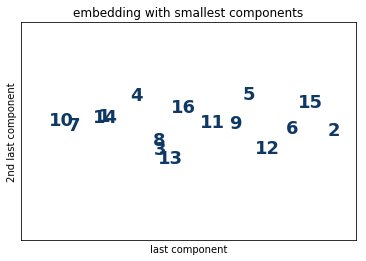

In [6]:
# plot last 2 components (of full matrix)  -- EV not negative enough; just noise
D, V = np.linalg.eig(S)
D, V = D[np.argsort(D)], V[:,np.argsort(D)]
X_embed = np.dot(V.real[:,:2], np.diag(np.sqrt(np.abs(D.real[:2]))))
plot_flowerpots_2d(X_embed, list(range(1,17)))
plt.title('embedding with smallest components');
plt.xlabel('last component');
plt.ylabel('2nd last component');
S_approx = np.dot(X_embed, X_embed.T)
print("MSQ Error: %.5f" % np.mean((S/np.abs(S).max() - S_approx/np.abs(S_approx).max())**2))

MSQ Error: 0.03172


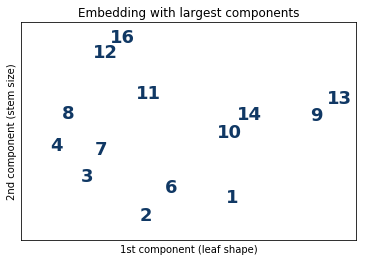

In [7]:
# plot first 2 components (of train matrix)
D, V = np.linalg.eig(S_train)
D, V = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V.real[:,:2], np.diag(np.sqrt(np.abs(D.real[:2]))))
plot_flowerpots_2d(X_embed, y+1)
plt.title('Embedding with largest components');
plt.xlabel('1st component (leaf shape)');
plt.ylabel('2nd component (stem size)');
S_approx = np.dot(X_embed, X_embed.T)
print("MSQ Error: %.5f" % np.mean((S_train/np.abs(S_train).max() - S_approx/np.abs(S_approx).max())**2))

In [8]:
# generate some input data relating to the similarities
# first 2 dim: stem size and leaf shape, rest noise
def get_input_data(random_dims=True):
    if random_dims:
        np.random.seed(15)
        X = np.random.randn(16, 5)
    else:
        X = np.zeros((16, 5))
    X[:,0] = np.array([17., 17., 17., 17., 25., 25., 25., 25., 38., 38., 38., 38., 50., 50., 50., 50.])
    X[:,1] = np.array([4., 3., 2., 1., 4., 3., 2., 1., 4., 3., 2., 1., 4., 3., 2., 1.])
    # mean center and normalize
    X -= np.mean(X, axis=0)
    s = np.std(X, axis=0)
    s[s==0] = 1.
    X /= s
    # split into train/test part
    return X[y,:], X[y_test,:]

MSQ Error: 0.04007


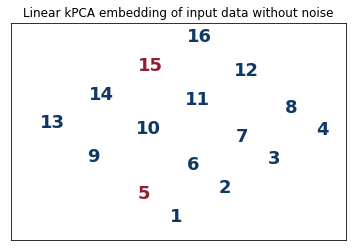

In [9]:
# embed based on linear kernel - no noise
X_train, X_test = get_input_data(False)
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X_train)
X_embed_test = kpca.transform(X_test)
plot_flowerpots_2d(X_embed, y+1, X_embed_test, y_test+1)
plt.title('Linear kPCA embedding of input data without noise');
# to compute the error, reorder the embedded data again
X_stacked = np.concatenate((X_embed, X_embed_test))[np.argsort(idx),:]
S_approx = np.dot(X_stacked, X_stacked.T)
print("MSQ Error: %.5f" % np.mean((S/np.abs(S).max() - S_approx/np.abs(S_approx).max())**2))

MSQ Error: 0.09656


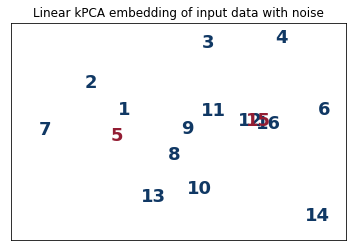

In [10]:
# embed based on linear kernel - with noise
X_train, X_test = get_input_data(True)
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X_train)
X_embed_test = kpca.transform(X_test)
plot_flowerpots_2d(X_embed, y+1, X_embed_test, y_test+1)
plt.title('Linear kPCA embedding of input data with noise')
X_stacked = np.concatenate((X_embed, X_embed_test))[np.argsort(idx),:]
S_approx = np.dot(X_stacked, X_stacked.T)
print("MSQ Error: %.5f" % np.mean((S/np.abs(S).max() - S_approx/np.abs(S_approx).max())**2))

Epoch 1/50
14/14 [==============================] - 2s 134ms/step - loss: 0.3740
Epoch 2/50
14/14 [==============================] - 0s 384us/step - loss: 0.2388
Epoch 3/50
14/14 [==============================] - 0s 251us/step - loss: 0.1483
Epoch 4/50
14/14 [==============================] - 0s 195us/step - loss: 0.1134
Epoch 5/50
14/14 [==============================] - 0s 284us/step - loss: 0.1191
Epoch 6/50
14/14 [==============================] - 0s 250us/step - loss: 0.1350
Epoch 7/50
14/14 [==============================] - 0s 192us/step - loss: 0.1363
Epoch 8/50
14/14 [==============================] - 0s 263us/step - loss: 0.1180
Epoch 9/50
14/14 [==============================] - 0s 277us/step - loss: 0.0939
Epoch 10/50
14/14 [==============================] - 0s 218us/step - loss: 0.0765
Epoch 11/50
14/14 [==============================] - 0s 172us/step - loss: 0.0709
Epoch 12/50
14/14 [==============================] - 0s 294us/step - loss: 0.0719
Epoch 13/50
14/14 [======

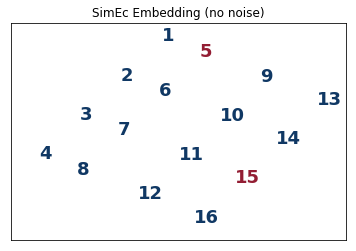

In [11]:
# embed with simec
X_train, X_test = get_input_data(False)
simec = SimilarityEncoder(X_train.shape[1], 2, S_train.shape[1], s_ll_reg=1., S_ll=S_train, opt=keras.optimizers.Adamax(lr=0.5))
simec.fit(X_train, S_train, 50)
X_embed = simec.transform(X_train)
X_embed_test = simec.transform(X_test)
plot_flowerpots_2d(X_embed, y+1, X_embed_test, y_test+1)
plt.title('SimEc Embedding (no noise)')
X_stacked = np.concatenate((X_embed, X_embed_test))[np.argsort(idx),:]
S_approx = np.dot(X_stacked, X_stacked.T)
print("MSQ Error: %.5f" % np.mean((S/np.abs(S).max() - S_approx/np.abs(S_approx).max())**2))

In [12]:
# check out the weights - mostly focus on first 2 dim
simec.model.layers[1].get_weights()

[array([[ 0.27476025, -0.17789172],
        [ 0.21233568,  0.32378882],
        [ 0.01434895,  0.01926874],
        [ 0.01767436, -0.01684698],
        [-0.00719833, -0.00967662]], dtype=float32),
 array([ 0.00315649,  0.01547986], dtype=float32)]

Epoch 1/50
14/14 [==============================] - 0s 5ms/step - loss: 0.4767
Epoch 2/50
14/14 [==============================] - 0s 228us/step - loss: 0.1812
Epoch 3/50
14/14 [==============================] - 0s 267us/step - loss: 0.1303
Epoch 4/50
14/14 [==============================] - 0s 258us/step - loss: 0.1242
Epoch 5/50
14/14 [==============================] - 0s 162us/step - loss: 0.1105
Epoch 6/50
14/14 [==============================] - 0s 175us/step - loss: 0.1126
Epoch 7/50
14/14 [==============================] - 0s 385us/step - loss: 0.1276
Epoch 8/50
14/14 [==============================] - 0s 197us/step - loss: 0.1164
Epoch 9/50
14/14 [==============================] - 0s 185us/step - loss: 0.0996
Epoch 10/50
14/14 [==============================] - 0s 166us/step - loss: 0.0997
Epoch 11/50
14/14 [==============================] - 0s 353us/step - loss: 0.0938
Epoch 12/50
14/14 [==============================] - 0s 240us/step - loss: 0.0802
Epoch 13/50
14/14 [========

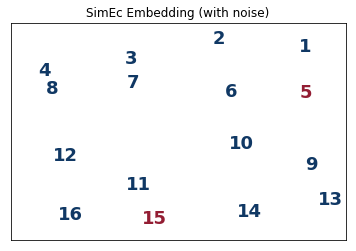

In [13]:
# embed with simec - with noise
X_train, X_test = get_input_data(True)
simec = SimilarityEncoder(X_train.shape[1], 2, S_train.shape[1], s_ll_reg=1., S_ll=S_train, opt=keras.optimizers.Adamax(lr=0.5))
simec.fit(X_train, S_train, 50)
X_embed = simec.transform(X_train)
X_embed_test = simec.transform(X_test)
plot_flowerpots_2d(X_embed, y+1, X_embed_test, y_test+1)
plt.title('SimEc Embedding (with noise)')
X_stacked = np.concatenate((X_embed, X_embed_test))[np.argsort(idx),:]
S_approx = np.dot(X_stacked, X_stacked.T)
print("MSQ Error: %.5f" % np.mean((S/np.abs(S).max() - S_approx/np.abs(S_approx).max())**2))

In [14]:
# it learns to only use the first 2 relevant features, not the 3 noise features
simec.model.layers[1].get_weights()

[array([[ 0.02776959, -0.31943965],
        [ 0.38503617,  0.01871875],
        [-0.00861213, -0.06493963],
        [ 0.01515204,  0.03144845],
        [ 0.00947615,  0.00858514]], dtype=float32),
 array([ 0.01342193,  0.00589182], dtype=float32)]

In [15]:
WWT = np.dot(simec.model.layers[1].get_weights()[0], simec.model.layers[1].get_weights()[0].T)

In [16]:
# we can also interpret why points are regarded as similar, e.g.
# flowerpots 4 and 1 are similar because of the first dimension (stem size),
# but not because of the second dimension (leaf shape);
# the last 3 random dimensions are irrelevant
np.dot(X_train[y+1==4], WWT)*X_train[y+1==1]

array([[ 0.1434945 , -0.27592276,  0.00913499, -0.00053563,  0.00070632]])

In [17]:
# flowerpots 4 and 16 are similar because of the second dimension (leaf shape),
# but not because of the first dimension (stem size);
# the last 3 random dimensions are again irrelevant
np.dot(X_train[y+1==4], WWT)*X_train[y+1==16]

array([[-0.16200991,  0.27592276, -0.00345775,  0.00117533,  0.00112934]])

In [18]:
# flowerpots 4 and 9 are not similar, mostly because of the second dimension (leaf shape),
# but also a bit because of the first dimension (stem size);
# the last 3 random dimensions are again irrelevant
np.dot(X_train[y+1==4], WWT)*X_train[y+1==9]

array([[-0.0509174 , -0.27592276, -0.01380738, -0.00087229,  0.00211895]])